#### What does Sumcheck prove?

For a polynomial `f : 𝔽² → 𝔽` (here `n = 3`) given *as a black box*,  
the Prover wants to convince the Verifier that
$$
S = \sum_{x \in \{0,1\}^3} f(x) \quad (= 36 \text{ in our example})
$$





without sending all `2ⁿ` evaluations.  
Sumcheck does it in *n* rounds:

1. **Round i** Prover sends a univariate degree-≤ d polynomial `gᵢ`.  
2. Verifier checks `gᵢ(0)+gᵢ(1) = claimed_sum`.  
3. Verifier samples a random field element `rᵢ` and sends it back.  
4. Both parties restrict `f` to that slice and continue with `n − i − 1` variables.

Soundness error ≤ `d/|𝔽|` per round.  (We use plain integers for clarity.)


evaluations=  [1, 2, 3, 4, 5, 6, 7, 8]
MLE polynomial in evaluation form:

a[0] = 1 => term = 1*(-(x0 - 1)*(x1 - 1)*(x2 - 1))
a[1] = 2 => term = 2*((x0 - 1)*(x1 - 1)*x2)
a[2] = 3 => term = 3*((x0 - 1)*x1*(x2 - 1))
a[3] = 4 => term = 4*(-(x0 - 1)*x1*x2)
a[4] = 5 => term = 5*(x0*(x1 - 1)*(x2 - 1))
a[5] = 6 => term = 6*(-x0*(x1 - 1)*x2)
a[6] = 7 => term = 7*(-x0*x1*(x2 - 1))
a[7] = 8 => term = 8*(x0*x1*x2)

Expanded polynomial:
4⋅x₀ + 2⋅x₁ + x₂ + 1


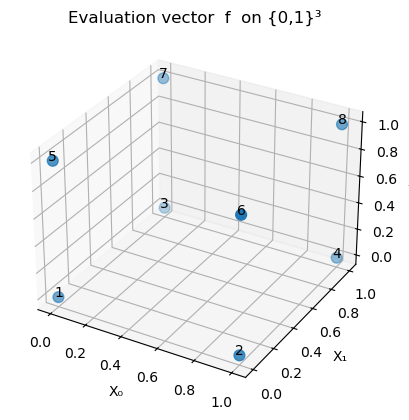


── First-round Sumcheck polynomial  h₁(X) ──
h₁(X) = 16  +  4·X
h₁(0) = 16        (even-half sum)
h₁(1) = 20    (odd-half  sum)
h₁(2) = 24  (third evaluation sent to the verifier)


In [3]:

import matplotlib.pyplot as plt
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D   


def bits(i, n):
    "Return i as an n-bit *list* (big-endian)."
    return list(map(int, format(i, f'0{n}b')))

def bits_reverse(i, n):
    "Little-endian version (least-significant bit first)."
    return bits(i, n)[::-1]

def eq_tilde(bits_i, u_vector):
    result=1
    for bit,u in zip(bits_i,u_vector):
        result *= (1-bit)*(1-u) + bit*u
    return result

def bits_of(i: int, n: int = 3):
    """Return the n-bit little-endian tuple of i (e.g. 5 → (1,0,1))."""
    return tuple((i >> j) & 1 for j in range(n))

f_vec = [1, 2, 3, 4, 5, 6, 7, 8]               # f(0,0,0) … f(1,1,1)
print("evaluations= ", f_vec)

n = 3
X0, X1, X2 = sp.symbols(f"x0:{n}")   # good
X = (X0, X1, X2)              # (X0, X1, X2)

f_tilde = sum(coeff * eq_tilde(bits(i, n), X)
              for i, coeff in enumerate(f_vec))


N = len(f_vec)

print("MLE polynomial in evaluation form:\n")
for i in range(N):
    term = eq_tilde(bits(i, n), X)
    print(f"a[{i}] = {f_vec[i]} => term = {f_vec[i]}*({term})")

print("\nExpanded polynomial:")
sp.pretty_print(sp.expand(f_tilde))

coords  = [bits_of(i, 3) for i in range(8)]   

# 3-D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
xs, ys, zs = zip(*coords)

ax.scatter(xs, ys, zs, s=60)

# annotate each vertex with its f-value
for (x0, x1, x2), val in zip(coords, f_vec):
    ax.text(x0, x1, x2, f"{val}", fontsize=10, ha='center')

ax.set_xlabel("X₀")
ax.set_ylabel("X₁")
ax.set_zlabel("X₂")
ax.set_title("Evaluation vector  f  on {0,1}³")

plt.show()

# first-round h₁(X) polynomial

# Even half  (X₀ = 0)
g1_0 = sum(f_vec[idx] for idx in range(8) if bits_of(idx)[0] == 0)
# Odd  half  (X₀ = 1)
g1_1 = sum(f_vec[idx] for idx in range(8) if bits_of(idx)[0] == 1)

# h₁(X) = a + b·X
a = g1_0
b = g1_1 - g1_0

print("\n── First-round Sumcheck polynomial  h₁(X) ──")
print(f"h₁(X) = {a}  +  {b}·X")
print(f"h₁(0) = {a}        (even-half sum)")
print(f"h₁(1) = {a + b}    (odd-half  sum)")
print(f"h₁(2) = {a + 2*b}  (third evaluation sent to the verifier)")




Verifier samples  α₀ = 8

Folded 4-point vector  f¹  on the (X₁,X₂) plane:
  (0, 0)  →  33
  (1, 0)  →  34
  (0, 1)  →  35
  (1, 1)  →  36


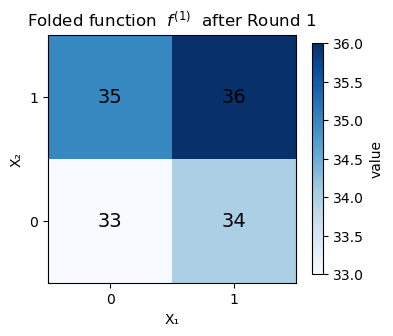

In [4]:
import random
random.seed(int(12345))        # deterministic for the demo

# verifier samples α₀
alpha0 = random.randint(2, 9)
print(f"Verifier samples  α₀ = {alpha0}")

# fold the vector:  f¹(x₁,x₂) = f(α₀, x₁, x₂) 
# even half  = indices where X₀ = 0   (0,1,2,3)
# odd  half  = indices where X₀ = 1   (4,5,6,7)
f_even = f_vec[0:4]
f_odd  = f_vec[4:8]

f_fold = [(1 - alpha0) * e + alpha0 * o     # (1-α)·even + α·odd
          for e, o in zip(f_even, f_odd)]

print("\nFolded 4-point vector  f¹  on the (X₁,X₂) plane:")
for idx, val in enumerate(f_fold):
    print(f"  ({bits_of(idx,2)[0]}, {bits_of(idx,2)[1]})  →  {val}")

import numpy as np
import matplotlib.pyplot as plt

# Arrange f_fold = [f(0,0), f(1,0), f(0,1), f(1,1)] into a 2-by-2 matrix
grid = np.array([[f_fold[0], f_fold[1]],
                 [f_fold[2], f_fold[3]]])

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(grid,
               cmap="Blues",
               origin="lower",            # (0,0) in the lower-left corner
               extent=[-0.5, 1.5, -0.5, 1.5],
               vmin=grid.min(), vmax=grid.max())

# Annotate each cell with its numeric value
for (i, j), val in np.ndenumerate(grid):
    ax.text(j, i, f"{val:.0f}",
            ha="center", va="center", color="black", fontsize=14)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xlabel("X₁")
ax.set_ylabel("X₂")
ax.set_title("Folded function  $f^{(1)}$  after Round 1")

plt.colorbar(im, shrink=0.75, label="value")
plt.show()


In [5]:
# partial sums over X₁
g2_0 = f_fold[0] + f_fold[1]          # X₁ = 0  (indices 00, 01)
g2_1 = f_fold[2] + f_fold[3]          # X₁ = 1  (indices 10, 11)

a2 = g2_0
b2 = g2_1 - g2_0                    

print("\n── Second-round polynomial  h₂(X)  ──")
print(f"h₂(X) = {a2:.1f}  +  {b2:.1f}·X")
print(f"h₂(0) = {a2:.1f}")
print(f"h₂(1) = {a2 + b2:.1f}")
print(f"h₂(2) = {a2 + 2*b2:.1f}")

print(f"a2        = {a2}")
print(f"b2        = {b2}")
print(f"h₂(0)+h₂(1)  = {a2 + (a2 + b2)}")
print(f"Σ f_fold     = {sum(f_fold)}")


# verifier checks the sum relation
assert abs((a2) + (a2 + b2) - sum(f_fold)) < 1e-9
print("Verifier check  h₂(0)+h₂(1)  =  Σ f¹(x)   ✓")



── Second-round polynomial  h₂(X)  ──
h₂(X) = 67.0  +  4.0·X
h₂(0) = 67.0
h₂(1) = 71.0
h₂(2) = 75.0
a2        = 67
b2        = 4
h₂(0)+h₂(1)  = 138
Σ f_fold     = 138
Verifier check  h₂(0)+h₂(1)  =  Σ f¹(x)   ✓


In [6]:
# sample α₁ 
alpha1 = random.randint(2, 9)
print(f"\nVerifier samples  α₁ = {alpha1}")

# fold again over X₁ 
f1_even = f_fold[0:2]                 # X₁ = 0 slice
f1_odd  = f_fold[2:4]                 # X₁ = 1 slice
f_fold2 = [(1 - alpha1) * e + alpha1 * o
           for e, o in zip(f1_even, f1_odd)]     # length 2

print("Folded vector  f²  (depends only on X₂ now):", f_fold2)

# build h₃(X) over the last variable X₂ 
g3_0, g3_1 = f_fold2                  
a3 = g3_0
b3 = g3_1 - g3_0

print("\n── Third-round polynomial  h₃(X)  ──")
print(f"h₃(X) = {a3:.1f}  +  {b3:.1f}·X")
print(f"h₃(0) = {a3:.1f}")
print(f"h₃(1) = {a3 + b3:.1f}")
print(f"h₃(2) = {a3 + 2*b3:.1f}")

# final leaf opening 
alpha2 = random.randint(0, 1)       
leaf   = f_fold2[alpha2]
print(f"\nVerifier picks  α₂ = {alpha2}   and asks for  f²(α₂) = {leaf:.1f}")
assert abs(leaf - (a3 + b3*alpha2)) < 1e-9
print("Leaf equals h₃(α₂)   ✓")

print("\n✅  Sumcheck for n = 3 completed – all rounds verified.\n")



Verifier samples  α₁ = 2
Folded vector  f²  (depends only on X₂ now): [37, 38]

── Third-round polynomial  h₃(X)  ──
h₃(X) = 37.0  +  1.0·X
h₃(0) = 37.0
h₃(1) = 38.0
h₃(2) = 39.0

Verifier picks  α₂ = 1   and asks for  f²(α₂) = 38.0
Leaf equals h₃(α₂)   ✓

✅  Sumcheck for n = 3 completed – all rounds verified.



In [7]:

n = 3
X = sp.symbols(f'X0:{n}')                       # (X0, X1, X2)
f_tilde = sum(coeff * eq_tilde(bits(i, n), X)
              for i, coeff in enumerate(f_vec))



# 2. Evaluate it at the verifier’s random challenges
poly_val = f_tilde.subs({X[0]: alpha0,
                         X[1]: alpha1,
                         X[2]: alpha2})

print("────────────────────────────────────────────")
print(f"f̃(α₀, α₁, α₂) = f̃({alpha0}, {alpha1}, {alpha2})  =  {poly_val}")
print(f"leaf opened in the final Sumcheck round         =  {leaf}")
print("────────────────────────────────────────────")
assert poly_val == leaf
print("✅  They match – Sumcheck transcript is fully consistent.\n")


────────────────────────────────────────────
f̃(α₀, α₁, α₂) = f̃(8, 2, 1)  =  38
leaf opened in the final Sumcheck round         =  38
────────────────────────────────────────────
✅  They match – Sumcheck transcript is fully consistent.



####  What’s still missing after Sumcheck?

At the end of the previous section the verifier is convinced that
$$
\text{leaf} = \sum_{b \in \{0,1\}^3} \text{f\_vec}[b] \cdot \text{eq}(b, \alpha)
$$



…but the verifier has **never seen `f_vec` itself**.
A cheating prover could:

1.  Run Sumcheck with any **fake** vector `f_fake`.
2.  Compute `leaf_fake = Σ f_fake[b]·eq(b, α)` (easy because α is known).
3.  Open that scalar in the last round.

Sumcheck would verify perfectly – yet the statement
“`leaf` equals _your_ polynomial at α” might be **false**.
We therefore need a separate mechanism that binds the prover to
a *single* multilinear polynomial before Sumcheck starts.


In [8]:
#  Cheating prover with *same* total sum  S  but different vector
import random, math

# Choose a fake vector with the same sum 
S_real = sum(f_vec)                        # 36 for [1…8]

print("Honest vector :", f_vec)
n = 3
X = sp.symbols(f'X0:{n}')                       # (X0, X1, X2)
f_tilde = sum(coeff * eq_tilde(bits(i, n), X)
              for i, coeff in enumerate(f_vec))

# 2. Evaluate it at the verifier’s random challenges
poly_val = f_tilde.subs({X[0]: alpha0,
                         X[1]: alpha1,
                         X[2]: alpha2})

print("Expanded polynomial:")
sp.pretty_print(sp.expand(f_tilde))
print("\n")
f_fake_same_sum = list(reversed(f_vec))    # [8,7,6,5,4,3,2,1]
delta = sum(f_fake_same_sum) - S_real      # here 36 - 36 = 0



assert sum(f_fake_same_sum) == S_real and f_fake_same_sum != f_vec

print("Fake vector   :", f_fake_same_sum, "(same sum, different values)")

fake_tilde = sum(coeff * eq_tilde(bits(i, n), X)
              for i, coeff in enumerate(f_fake_same_sum))

# Evaluate it at the verifier’s random challenges
poly_val = fake_tilde.subs({X[0]: alpha0,
                         X[1]: alpha1,
                         X[2]: alpha2})

print("Expanded polynomial:")
sp.pretty_print(sp.expand(fake_tilde))
print("\n")


print("Total sum S   :", S_real, "\n")

def line_triplet(v0, v1):
    return (v0, v1, v0 + 2*(v1 - v0))

def sumcheck_transcript(vec, α0, α1):
    g1_0, g1_1 = sum(vec[:4]), sum(vec[4:])
    h1 = line_triplet(g1_0, g1_1)

    even, odd = vec[:4], vec[4:]
    f_fold = [(1-α0)*e + α0*o for e,o in zip(even, odd)]

    g2_0, g2_1 = f_fold[0]+f_fold[1], f_fold[2]+f_fold[3]
    h2 = line_triplet(g2_0, g2_1)

    even2, odd2 = f_fold[:2], f_fold[2:]
    f_fold2 = [(1-α1)*e + α1*o for e,o in zip(even2, odd2)]

    g3_0, g3_1 = f_fold2
    h3 = line_triplet(g3_0, g3_1)

    α2   = random.randint(0, 1)     
    leaf = eval_line(h3, α2) 
    return h1, h2, h3, α2, leaf

def eval_line(h, x):
    return h[0] + (h[1]-h[0])*x

def verifier_accepts(h1,h2,h3, α0,α1,α2, leaf, S):
    """Return True iff all 4 Sumcheck equalities hold."""
    return (
        math.isclose(h1[0]+h1[1], S) and
        math.isclose(h2[0]+h2[1], eval_line(h1, α0)) and
        math.isclose(h3[0]+h3[1], eval_line(h2, α1)) and
        math.isclose(leaf,          h3[α2])
    )

h1_h, h2_h, h3_h, α2_h, leaf_h = sumcheck_transcript(f_vec,  alpha0, alpha1)
h1_c, h2_c, h3_c, α2_c, leaf_c = sumcheck_transcript(f_fake_same_sum,
                                                     alpha0, alpha1)

print("Verifier challenges: α0 =", alpha0, "α1 =", alpha1, "α2 =", α2_c)
print("Honest leaf =", leaf_h, "   Fake leaf =", leaf_c, "\n")

def poly_str(h):
    """Return 'a + b·X' string for a degree-1 poly given (h0,h1, _)."""
    a, b = h[0], h[1] - h[0]
    return f"{a:.1f}  +  {b:.1f}·X"

def run_and_explain(tag, h1,h2,h3, α0,α1,α2, leaf, S):
    print(f"\n===== Verifier run on {tag} transcript =====")
    print("Prover’s messages:")
    print("  h₁ values =", h1, "  ⇒  h₁(X) =", poly_str(h1))
    print("  h₂ values =", h2, "  ⇒  h₂(X) =", poly_str(h2))
    print("  h₃ values =", h3, "  ⇒  h₃(X) =", poly_str(h3))
    print("  leaf =", leaf, "\n")

    # --- algebraic checks ----------------------------------
    check1 = math.isclose(h1[0] + h1[1], S)
    check2 = math.isclose(h2[0] + h2[1], eval_line(h1, α0))
    check3 = math.isclose(h3[0] + h3[1], eval_line(h2, α1))
    check4 = math.isclose(leaf        , h3[α2])

    print(f"①  h₁(0)+h₁(1) = {h1[0]+h1[1]:>8}    vs  S = {S:<8}        → {check1}")
    print(f"②  h₂(0)+h₂(1) = {h2[0]+h2[1]:>8}    vs  h₁(α₀) = {eval_line(h1,α0):<8}  → {check2}")
    print(f"③  h₃(0)+h₃(1) = {h3[0]+h3[1]:>8}    vs  h₂(α₁) = {eval_line(h2,α1):<8}  → {check3}")
    print(f"④  leaf        = {leaf:>8}    vs  h₃(α₂) = {h3[α2]:<8}       → {check4}")

    all_pass = check1 and check2 and check3 and check4
    print("Result:", "✔ PASSED" if all_pass else "✖ REJECTED")
    return all_pass

ok_honest = run_and_explain("HONEST",
                            h1_h,h2_h,h3_h,
                            alpha0,alpha1,α2_h,
                            leaf_h, S_real)

ok_fake   = run_and_explain("FAKE  ",
                            h1_c,h2_c,h3_c,
                            alpha0,alpha1,α2_c,
                            leaf_c, S_real)   
print("Verifier result on HONEST transcript :", ok_honest)
print("Verifier result on FAKE   transcript :", ok_fake, "\n")

def eval_mle(evals, u):
    return sum(e*eq_tilde(bits_of(i,3), u) for i,e in enumerate(evals))

u_test = (0,0,0)
print(f"At point u = {u_test}:")
print("  honest f̃(u) =", eval_mle(f_vec, u_test))
print("  fake   f̃(u) =", eval_mle(f_fake_same_sum, u_test),
      "← different but still passed Sumcheck!")


Honest vector : [1, 2, 3, 4, 5, 6, 7, 8]
Expanded polynomial:
4⋅X₀ + 2⋅X₁ + X₂ + 1


Fake vector   : [8, 7, 6, 5, 4, 3, 2, 1] (same sum, different values)
Expanded polynomial:
-4⋅X₀ - 2⋅X₁ - X₂ + 8


Total sum S   : 36 

Verifier challenges: α0 = 8 α1 = 2 α2 = 0
Honest leaf = 38    Fake leaf = -28 


===== Verifier run on HONEST transcript =====
Prover’s messages:
  h₁ values = (10, 26, 42)   ⇒  h₁(X) = 10.0  +  16.0·X
  h₂ values = (67, 71, 75)   ⇒  h₂(X) = 67.0  +  4.0·X
  h₃ values = (37, 38, 39)   ⇒  h₃(X) = 37.0  +  1.0·X
  leaf = 38 

①  h₁(0)+h₁(1) =       36    vs  S = 36              → True
②  h₂(0)+h₂(1) =      138    vs  h₁(α₀) = 138       → True
③  h₃(0)+h₃(1) =       75    vs  h₂(α₁) = 75        → True
④  leaf        =       38    vs  h₃(α₂) = 38             → True
Result: ✔ PASSED

===== Verifier run on FAKE   transcript =====
Prover’s messages:
  h₁ values = (26, 10, -6)   ⇒  h₁(X) = 26.0  +  -16.0·X
  h₂ values = (-49, -53, -57)   ⇒  h₂(X) = -49.0  +  -4.0·X
  h₃ values

#### Why add a (mock) PCS?

* **Problem:** Sumcheck only checks algebra; the verifier never sees the  
  evaluation vector **f**. A prover can swap in a different vector  
  **f_fake** after learning the challenges and still pass all four checks.

* **PCS idea:** Prover first sends a digest `C = Hash(f)`.  
  After Sumcheck it must open **the same** digest together with the claimed
  value `f(α₀,α₁,α₂)`.

* **Security:**  
  * Honest → digest matches **and** value matches → verifier accepts.  
  * Cheater → digest mismatch (or wrong value) → verifier rejects.

The tiny SHA-256 PCS below demonstrates this:  
`pcs_open` prints *why* it succeeds on the honest vector and fails on the
fake one.

In [12]:

import hashlib, json, math

def _canonical(evals):
    return [int(x) for x in evals]

def pcs_commit(evals):
    blob = json.dumps(_canonical(evals), separators=(",", ":")).encode()
    return hashlib.sha256(blob).hexdigest()

def pcs_open(evals, point, claimed_val, commitment, *, verbose=True):
    """
    Return (all_ok, digest_ok, value_ok)
    • If verbose=True, print a one-line explanation whenever something fails.
    """
    digest_ok = (pcs_commit(evals) == commitment)
    if verbose and not digest_ok:
        print("[PCS] digest mismatch "
              f"(got {commitment[:12]}…, expected {pcs_commit(evals)[:12]}… )")

    poly_val = sum(int(e) * eq_tilde(bits_of(i, 3), point)
                   for i, e in enumerate(evals))
    value_ok = math.isclose(poly_val, claimed_val)
    if verbose and digest_ok and not value_ok:
        print("[PCS] value mismatch "
              f"(claimed {claimed_val}, recomputed {poly_val})")

    if verbose and digest_ok and value_ok:
        print("[PCS] ✔ digest & value both correct")

    return digest_ok and value_ok, digest_ok, value_ok

print(" Honest evaluation vector  :", f_vec)
print(" Fake   evaluation vector  :", f_fake_same_sum, "(same Σ, different order)\n")

commit_honest = pcs_commit(f_vec)
commit_fake   = pcs_commit(f_fake_same_sum)
print("Honest commitment digest :", commit_honest)
print("Fake   commitment digest :", commit_fake)
print("   Digests equal ? ", commit_honest == commit_fake, "\n")

query_pt = (alpha0, alpha1, α2_h)               
leaf_h   = eval_mle(f_vec , query_pt)          
leaf_f   = eval_mle(f_fake_same_sum, query_pt)        


ok_honest, dig_honest, val_honest = pcs_open(f_vec , query_pt, leaf_h, commit_honest)
ok_fake  , dig_fake , val_fake  = pcs_open(f_fake_same_sum, query_pt, leaf_f, commit_honest)

print("PCS-open on HONEST data :", ok_honest)
print("PCS-open on FAKE  data  :", ok_fake, "\n",
      "← fails (digest mismatch)")

 Honest evaluation vector  : [1, 2, 3, 4, 5, 6, 7, 8]
 Fake   evaluation vector  : [8, 7, 6, 5, 4, 3, 2, 1] (same Σ, different order)

Honest commitment digest : b2ddd6543011e658aaebc223b42021e89fa9a18bd1f2207f6cb68e73ca5688b3
Fake   commitment digest : 97c729b9b6163a0473bfc1d90d5bd4d8f03013dfaf2531be15f58065afe80e3f
   Digests equal ?  False 

[PCS] ✔ digest & value both correct
[PCS] digest mismatch (got b2ddd6543011…, expected 97c729b9b616… )
PCS-open on HONEST data : True
PCS-open on FAKE  data  : False 
 ← fails (digest mismatch)


#### Fact 1 — “Evaluation = Sum”

For a multilinear-extension polynomial written in evaluation form:

$$
\tilde{f}(\mathbf{X}) = \sum_{i \in {0,1}^n} a_i,E_i(\mathbf{X}), \quad
E_i(\mathbf{X}) = \prod_{j=0}^{n-1}
\left( \mathrm{bits}(i)_j,X_j + (1 - \mathrm{bits}(i)_j)(1 - X_j) \right)
$$

a single point-evaluation can be rewritten as an inner product:

$$
\boxed{
\tilde{f}(\mathbf{u}) = \sum_{i \in {0,1}^n} a_i,\underbrace{E_i(\mathbf{u})}{=,eq(\mathbf{u}, i)}
= \left\langle
\underbrace{(a_0, \dots, a{2^n - 1})}{f{\text{vec}}},
\underbrace{(eq(\mathbf{u}, 0), \dots, eq(\mathbf{u}, 2^n - 1))}{w{\text{vec}}}
\right\rangle
}
$$
	•	Left-hand side — the usual “plug-and-chug” evaluation.
	•	Right-hand side — a length-$2^n$ sum, exactly the form the Sumcheck protocol can certify.

⸻

In the notebook below we will:
1. build the equality-function vector $w_{\text{vec}}$ for the verifier’s random point $\mathbf{u} = (\alpha_0, \alpha_1, \alpha_2)$;
2.	compute the inner product $\langle f_{\text{vec}}, w_{\text{vec}} \rangle$;
3.	show it equals the direct polynomial value computed earlier.

That makes the algebraic bridge between an MLE evaluation and a Sumcheck sum concrete.

In [21]:
# Fact 1 : a single evaluation is an inner product 
u_point = (alpha0, alpha1, alpha2)                     

try:
    _ = poly_honest      
except NameError:
    poly_honest = sp.expand(sum(
        int(f) * eq_tilde(bits_of(i, 3), X)     
        for i, f in enumerate(f_vec)
    ))

print("\nFull multilinear extension  f̃(X₀,X₁,X₂):")
sp.pretty_print(poly_honest)


# Build equality-function vector  w  (length 8)
w_vec = [eq_tilde(bits_of(i, 3), u_point) for i in range(8)]


print("Verifier’s point  u =", u_point, "\n")
print(" i   bits       f_vec[i]      w[i]   contribution  f[i]·w[i]")
print("───  ─────      ─────────     ─────  ────────────────────────")

contribs = []
for i, (f, w) in enumerate(zip(f_vec, w_vec)):
    c = f * w
    contribs.append(c)
    print(f"{i:2}   {bits_of(i,3)}     {f:>2}        {w:>5}        {c:>6}")

inner_prod = sum(contribs)
poly_val   = eval_mle(f_vec, u_point)                  # direct evaluation

print("\nΣ contributions =", inner_prod)
print("Direct polynomial value f̃(u) =", poly_val)

assert inner_prod == poly_val
print("\n✔  f̃(u) equals the length-8 inner product ⟨f_vec , w_vec⟩.")



Full multilinear extension  f̃(X₀,X₁,X₂):
X₀ + 2⋅X₁ + 4⋅X₂ + 1
Verifier’s point  u = (8, 2, 1) 

 i   bits       f_vec[i]      w[i]   contribution  f[i]·w[i]
───  ─────      ─────────     ─────  ────────────────────────
 0   (0, 0, 0)      1            0             0
 1   (1, 0, 0)      2            0             0
 2   (0, 1, 0)      3            0             0
 3   (1, 1, 0)      4            0             0
 4   (0, 0, 1)      5            7            35
 5   (1, 0, 1)      6           -8           -48
 6   (0, 1, 1)      7          -14           -98
 7   (1, 1, 1)      8           16           128

Σ contributions = 17
Direct polynomial value f̃(u) = 17

✔  f̃(u) equals the length-8 inner product ⟨f_vec , w_vec⟩.


#### Fact #2 — Sumcheck fold ≙ FRI split-fold

At every round both protocols take a length-$2m$ vector, cut it into  
`even` and `odd` halves, and compute:

$$
\texttt{fold}(\alpha) = (1 - \alpha)\,\texttt{even} + \alpha\,\texttt{odd}
$$

- **Sumcheck** uses it to reduce the multilinear inner-product dimension.  
- **FRI** uses the *same* map to reduce a Reed–Solomon codeword.

Below we fold the honest evaluation vector two ways:

1. with the hand-written Sumcheck comprehension already in the notebook,  
2. use folding code from `basefold_rs_pcs.py`, the helper the real  
   FRI implementation calls.

They land on exactly the same 4-entry vector, confirming the equivalence.

In [32]:


'''
The actual folding from the implementation itself : 

            # fold f_code
            f_code_folded = [(Field(1)-alpha) * (f_code[2*j] + f_code[2*j+1]) / 2 
                      + alpha * (f_code[2*j] - f_code[2*j+1]) / (2 * coset * twiddles[j]) 
                      for j in range(len(f_code)//2)]
'''

def fri_split_fold(even, odd, alpha):
    """
    Return (1-alpha)*even + alpha*odd   element-wise, exactly what FRI
    does to halve a Reed–Solomon codeword.  Works for plain lists of
    field elements as used in this demo.
    """
    return [(1 - alpha) * e + alpha * o for e, o in zip(even, odd)]


even = f_vec[:4]          # indices 000,001,010,011  (X₀=0)
odd  = f_vec[4:]          # indices 100,101,110,111  (X₀=1)
α    = alpha0             # verifier’s first challenge

print("even =", even)
print("odd  =", odd)
print("α =", α, "\n")

# Sumcheck’s explicit comprehension
sumcheck_fold = [(1-α)*e + α*o for e, o in zip(even, odd)]
print("Sumcheck fold :", sumcheck_fold)

# FRI’s comprehension
pcs = BASEFOLD_RS_PCS(MerkleTree, debug=0)
fri_fold = fri_split_fold(even, odd, α)  
print("FRI      fold :", fri_fold, "\n")

assert sumcheck_fold == fri_fold
print("✔  Identical output ⇒ both protocols share the very same linear map.")


even = [1, 2, 3, 4]
odd  = [5, 6, 7, 8]
α = 8 

Sumcheck fold : [33, 34, 35, 36]
FRI      fold : [33, 34, 35, 36] 

✔  Identical output ⇒ both protocols share the very same linear map.


### Step 4 — Gluing FRI + Sumcheck into *one* PCS

**Goal:** prove the public statement $f(u) = v$ without revealing the  
whole evaluation vector.

---

#### 1 · Re-phrase the claim

- Pick the **same** random challenges  
  $\alpha = (\alpha_0, \dots, \alpha_{n-1})$ that will drive both  
  sub-protocols.
- Let $w := f(\alpha)$.

Now proving $f(u) = v$ is equivalent to proving these two facts:

1. **FRI-fact** $f(\alpha) = w$  
2. **Sumcheck-fact** $v = \sum_b f(b) \, eq(u, b)$

---

#### 2 · One transcript, two jobs

| round | prover message | α used by |
|-------|----------------|-----------|
| commit | RS–codeword → Merkle root $C_0$ | — |
| 0 | send $h_1$, fold with $\alpha_0$ | FRI & Sumcheck |
| 1 | send $h_2$, fold with $\alpha_1$ | FRI & Sumcheck |
| … | … | … |
| n | send $h_n$; open **one** code symbol = $w$ | FRI constant & Sumcheck leaf |

- **FRI** + Merkle paths ⇒ verifier accepts $f(\alpha) = w$  
- **Sumcheck**, fed with the *same* $\alpha$’s and that single scalar  
  $w$, ⇒ verifier accepts $\sum f(b) \, eq(u, b) = v$  
  ⇒ Algebra then forces $f(u) = v$

---

#### 3 · Soundness intuition

Because every fold is checked **twice** (FRI *and* Sumcheck), a cheating  
prover must satisfy both or be caught with probability  
$\approx 1 / |F|$ per round. The verifier inspects only  
$O(\log n)$ field elements.

> **Shared randomness = one proof**  
> FRI authenticates one hidden evaluation $w$;  
> Sumcheck converts that single fact into the original claim  
> $f(u) = v$.

### End-to-end picture for \(n = 3\)

```mermaid
flowchart TD
    %% Style tweaks
    classDef b fill:#f0f0ff,stroke:#9aa;
    classDef s fill:#fff8dc,stroke:#d9a;

    %% Commit phase
    A0(["**8-entry eval&nbsp;vector**<br>f = [1..8]"]):::b
    A1(["Reed–Solomon encode →<br>codeword c₀ (len = 8·ρ)"]):::b
    A2(["Merkle-root<br>**C₀**"]):::b

    A0 -->|encode| A1 -->|Merkle| A2
    subgraph G1[ Prover side ]
    A0;A1;A2
    end

    %% Shared loop
    B0(("k = 3 rounds")):::s

    %% Round boxes
    R1["Round 0<br>split even/odd<br>fold with α₀"]
    R2["Round 1<br>split even/odd<br>fold with α₁"]
    R3["Round 2<br>split even/odd<br>fold with α₂ (last)"]

    %% Folding arrows
    A2 --> R1 --> R2 --> R3

    %% Sumcheck track
    subgraph Sumcheck[ Sumcheck track ]
        direction LR
        S8["f (8)"]-->S4["f¹ (4)"]-->S2["f² (2)"]-->S1["leaf (1)"]
    end

    %% FRI track
    subgraph FRI[ FRI track ]
        direction LR
        C8["c₀ (8·ρ)"]-->C4["c₁"]-->C2["c₂"]-->C1["constant w"]
    end

    %% α arrows
    R1 -- same α₀ --> C4 & S4
    R2 -- same α₁ --> C2 & S2
    R3 -- same α₂ --> C1 & S1

    %% Verifier checks
    V1["Merkle paths + FRI\n⇒ accept f(α)=w?"]:::b
    V2["Sumcheck equalities\n⇒ accept Σf eq(u,·)=v?"]:::b
    C1 --> V1
    S1 --> V2
    V1 --> V2

    %% Final statement
    V2 --> V3(["✓ conclude  f(u)=v"]):::b


In [30]:
# Basefold PCS demo  (n = 3, f = [1…8]) 
import basefold_rs_pcs as pcs_mod              
from merlin.merlin_transcript import MerlinTranscript
from utils import inner_product               

Field            = pcs_mod.Field              
MerkleTree       = pcs_mod.MerkleTree
BASEFOLD_RS_PCS  = pcs_mod.BASEFOLD_RS_PCS
MLEPolynomial    = pcs_mod.MLEPolynomial

# public instance 
evals   = [Field(i) for i in range(1, 9)]          # f = [1,2,3,4,5,6,7,8]
u_point = [Field(alpha0), Field(alpha1), Field(alpha2)]   # the same α’s

MLEPolynomial.set_field_type(Field)
f_mle = MLEPolynomial(evals, 3)

# v = f(u)
eq_vec = MLEPolynomial.eqs_over_hypercube(u_point)
v_true = inner_product(evals, eq_vec, Field.zero())
assert f_mle.evaluate(u_point) == v_true

print(f"Public claim :  f({u_point}) = v = {v_true}\n")

# set-up prover / verifier objects 
pcs = BASEFOLD_RS_PCS(MerkleTree, debug=2)     
pcs.security_bits = 32 
tr  = MerlinTranscript(b"basefold-rs-demo")

# commitment
f_cm = pcs.commit(f_mle)
print("Commitment root :", f_cm.cm, "…\n")

# prover produces argument 
print("🕐  Prover: generating proof …")
v_proved, argument = pcs.prove_eval(f_cm, f_mle, u_point, tr.fork(b"prove"))
print("ℹ️  Proof generated.\n")
assert v_proved == v_true

# verifier checks
print("🕐  Verifier: checking proof …")
ok = pcs.verify_eval(f_cm, u_point, v_true, argument, tr.fork(b"verify"))
print("✅  Proof verified =", ok)


Public claim :  f([8, 2, 1]) = v = 17

Commitment root : e219f04c2b44cc862b9b481e4db03e9e79d4b280b7e1ba860fcb683f3d7f5b1d …

🕐  Prover: generating proof …
P> f_len=8, k=3, c_len =64
P> check f0_code
P> check f0_code passed
P> Round 0
P> alpha[0] = 2117879509
P> Round 1
P> alpha[1] = 4293038735
P> Round 2
P> alpha[2] = 3383722775
P> final_sum(33557169405938763609452287200546002464000) = f(alpha_vec)*eq(alpha_vec), 24238848080 * 1384437465641261761208756550800
P> queries=22, query_indices=[[(6, 7), (2, 3), (0, 1)], [(50, 51), (24, 25), (12, 13)], [(40, 41), (20, 21), (10, 11)], [(12, 13), (6, 7), (2, 3)], [(8, 9), (4, 5), (2, 3)], [(24, 25), (12, 13), (6, 7)], [(62, 63), (30, 31), (14, 15)], [(4, 5), (2, 3), (0, 1)], [(54, 55), (26, 27), (12, 13)], [(58, 59), (28, 29), (14, 15)], [(28, 29), (14, 15), (6, 7)], [(46, 47), (22, 23), (10, 11)], [(42, 43), (20, 21), (10, 11)], [(52, 53), (26, 27), (12, 13)], [(30, 31), (14, 15), (6, 7)], [(2, 3), (0, 1), (0, 1)], [(34, 35), (16, 17), (8, 9)],